In [2]:
!nvidia-smi

Fri Jul 12 17:20:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.92                 Driver Version: 546.92       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8               5W / 132W |   5414MiB / 12282MiB |     20%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Import relevant modules

# Import modules for vector calculations
import numpy as np
import scipy as sp
import pandas as pd
import scipy.linalg as la
import scipy.optimize as opt

# Import modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
%matplotlib inline

# Import modules for file handling 
import os
import io
import sys
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from tifffile import imread, imsave
from skimage import io, measure
import time

# Import modules for Deep Learning
import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchsummary import summary
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
torch.set_float32_matmul_precision("medium|high")

# Import custom modules
from Gap_UNetResblock import UNet
from GAPUNet import GAPUNet
from AttentionUNetArchitecture import AttentionUNet
from BinomDataset2 import BinomDataset

In [4]:
# Using the GPU for computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
Data = np.concatenate((imread(r'trainingDataGT.tif'), imread(r'testDataGT.tif')))

(2048, 512, 512)


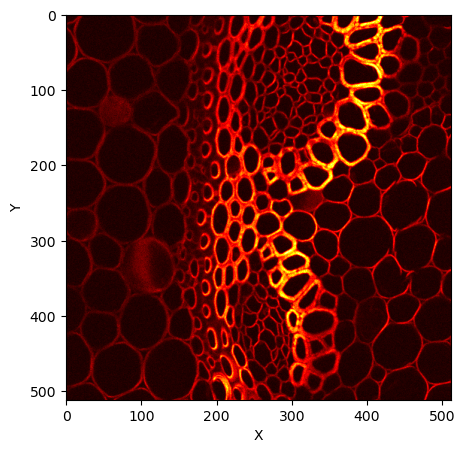

In [6]:
# Review the Dataset
plt.figure(figsize=(5,5))
plt.imshow(Data[1842], cmap='hot')
print(Data.shape)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [7]:
def psnrToString(inp):
    if inp < 0:
        return "m"+str(-inp)
    else:
        return str(inp)
    
# We set the pseudo PSNR range used for splitting the images into input and target
minpsnr = -40
maxpsnr = -5

name = psnrToString(minpsnr) + "to" + psnrToString(maxpsnr) + "-256x256"
CHECKPOINT_PATH = "./models/" 

In [8]:
Train_Psnr_Distribution = torch.randint(torch.tensor([minpsnr]), torch.tensor([maxpsnr]), (round(Data.shape[0]*0.8),))
len(Train_Psnr_Distribution)

1638

In [9]:
Valid_Psnr_Distribution = torch.randint(torch.tensor([minpsnr]), torch.tensor([maxpsnr]), (round(Data.shape[0]*0.2,),))
len(Valid_Psnr_Distribution)

410

In [10]:
maxepochs = 20 # Train for longeer if needed

# Create the pytorch dataset
Train_Dataset = BinomDataset(Data[:round(Data.shape[0]*0.9)], 1, 256, minpsnr, maxpsnr, virtSize= 500 *32)
Valid_Dataset = BinomDataset(Data[round(Data.shape[0]*0.9):], 1, 256, minpsnr, maxpsnr)

# Create the Dataloaders for the training and validation sets
Train_Loader = DataLoader(Train_Dataset, batch_size = 32, shuffle = True, drop_last = True, pin_memory=False)
Validation_Loader = DataLoader(Valid_Dataset, batch_size = 32, shuffle = False, drop_last = True, pin_memory=False)

img_input, psnr_map, target_img  = next(iter(Train_Loader))
print("Image Input: ",img_input.shape)
print("Psnr_Map", psnr_map.shape)
print("target_img", target_img.shape)

# Define the callbacks for the model training and validation.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min', verbose=True)


Image Input:  torch.Size([32, 1, 256, 256])
Psnr_Map torch.Size([32, 1, 256, 256])
target_img torch.Size([32, 1, 256, 256])


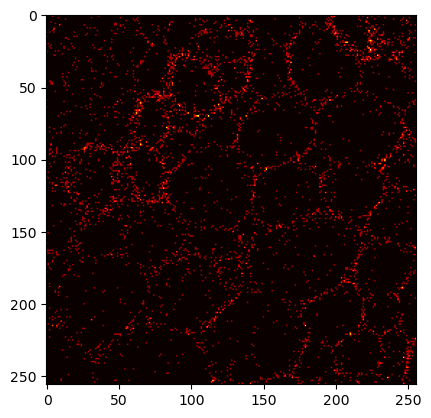

In [11]:
plt.imshow(img_input.detach().cpu().numpy()[0,0], cmap='hot')
plt.show()

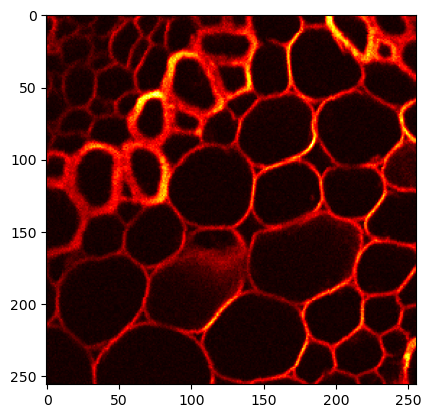

In [12]:
plt.imshow(target_img.detach().cpu().numpy()[0,0], cmap='hot')
plt.show()

In [13]:
# Define the Attention Unet Model

# Define the Hyperparameters of the Model:
initial_channels = 8
image_channels = 1
blocks_per_channel = 2
n_groups = 8
n_heads = 8
channels_list = [32, 64, 128, 256, 512]
dim_k = 64
num_groups = 8 
reduction_factor = 4
dropout_rate = 0.1
time_channels = 128
bottleneck_factor = 2
units = 128
bottleneck_units = 64
conv_type = "Residual_Block"
attn_type_list = [None, None, None, None, None]
merge_type = "add"
middle_attn_type = "GroupQueryAttention"
maxpsnr = -5.0
transpose = True
minpsnr = -40.0
num_timesteps = 1024

# Define the Attention Network:
AttnUNet = AttentionUNet(
        initial_channels = initial_channels,
        channels_list = channels_list,
        blocks_per_channel = blocks_per_channel,
        n_groups = n_groups,
        n_heads = n_heads,
        dim_k = dim_k,
        dropout_rate = dropout_rate,
        time_channels = time_channels,
        bottleneck_factor = bottleneck_factor,
        units = units,
        bottleneck_units= bottleneck_units,
        conv_type = conv_type,
        attn_type_list = attn_type_list,
        merge_type = merge_type,
        maxpsnr = maxpsnr,
        minpsnr = minpsnr,
        num_timesteps = num_timesteps,
        image_channels = image_channels,
        reduction_factor= reduction_factor,
        num_groups= num_groups,
        middle_attn_type= middle_attn_type,
        upsample_type = "transpose"
        )

In [14]:
AttnUNet = AttnUNet.to(device)
AttnUNet

AttentionUNet(
  (Image_Projection): LazyConv2d(0, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (input_norm): GroupNorm(8, 8, eps=1e-05, affine=True)
  (input_Mish): Mish()
  (Temporal_Embedding): Temporal_Embedder(
    (Linear_1): Linear(in_features=8, out_features=32, bias=True)
    (Linear_2): Linear(in_features=32, out_features=32, bias=True)
    (Mish_1): Mish()
    (Mish_2): Mish()
  )
  (Final_Upsample): Up_Block(
    (Conv_Block): Residual_Block(
      (time_embedding): Linear(in_features=32, out_features=8, bias=True)
      (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (GroupNorm_1): GroupNorm(8, 16, eps=1e-05, affine=True)
      (GroupNorm_2): GroupNorm(8, 8, eps=1e-05, affine=True)
      (Batch_Norm_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True,

In [29]:
(8/4, 8)

(2.0, 8)

In [15]:
psnr_map[0].max()

tensor(-33.7066)

In [17]:
# Base AttnUNet with Attention in the Middleblock
summary(AttnUNet, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             288
              Mish-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              Mish-4                   [-1, 32]               0
 Temporal_Embedder-5                   [-1, 32]               0
            Conv2d-6          [-1, 8, 256, 256]             368
         GroupNorm-7          [-1, 8, 256, 256]              16
              Mish-8          [-1, 8, 256, 256]               0
            Conv2d-9          [-1, 8, 256, 256]              64
      BatchNorm2d-10          [-1, 8, 256, 256]              16
        GroupNorm-11          [-1, 8, 256, 256]              16
             Mish-12          [-1, 8, 256, 256]               0
           Conv2d-13          [-1, 8, 256, 256]             576
          Dropout-14          [-1, 8, 2

In [38]:
# AttnUNet with attention in the last encoder layer and middle block
summary(AttnUNet, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             288
              Mish-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              Mish-4                   [-1, 32]               0
 Temporal_Embedder-5                   [-1, 32]               0
            Conv2d-6          [-1, 8, 256, 256]             368
         GroupNorm-7          [-1, 8, 256, 256]              16
              Mish-8          [-1, 8, 256, 256]               0
            Conv2d-9          [-1, 8, 256, 256]              64
      BatchNorm2d-10          [-1, 8, 256, 256]              16
        GroupNorm-11          [-1, 8, 256, 256]              16
             Mish-12          [-1, 8, 256, 256]               0
           Conv2d-13          [-1, 8, 256, 256]             576
          Dropout-14          [-1, 8, 2

In [16]:
# AttnUNet using Efficient Residual Blocks
summary(AttnUNet, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             288
              Mish-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              Mish-4                   [-1, 32]               0
 Temporal_Embedder-5                   [-1, 32]               0
            Conv2d-6          [-1, 8, 256, 256]             368
         GroupNorm-7          [-1, 8, 256, 256]              16
              Mish-8          [-1, 8, 256, 256]               0
            Conv2d-9          [-1, 8, 256, 256]              64
      BatchNorm2d-10          [-1, 8, 256, 256]              16
        GroupNorm-11          [-1, 8, 256, 256]              16
             Mish-12          [-1, 8, 256, 256]               0
           Conv2d-13         [-1, 16, 256, 256]             128
        Dropout2d-14         [-1, 16, 2

In [17]:
# AttnUNet using Efficient Residual Blocks
summary(AttnUNet, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             288
              Mish-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              Mish-4                   [-1, 32]               0
 Temporal_Embedder-5                   [-1, 32]               0
            Conv2d-6          [-1, 8, 256, 256]             368
         GroupNorm-7          [-1, 8, 256, 256]              16
              Mish-8          [-1, 8, 256, 256]               0
            Conv2d-9          [-1, 8, 256, 256]              64
      BatchNorm2d-10          [-1, 8, 256, 256]              16
        GroupNorm-11          [-1, 8, 256, 256]              16
             Mish-12          [-1, 8, 256, 256]               0
           Conv2d-13          [-1, 4, 256, 256]              32
        Dropout2d-14          [-1, 4, 2

In [23]:
# AttnUNet using Squeeze And Extraction Residual Blocks
summary(AttnUNet, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             288
              Mish-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              Mish-4                   [-1, 32]               0
 Temporal_Embedder-5                   [-1, 32]               0
            Conv2d-6          [-1, 8, 256, 256]             368
         GroupNorm-7          [-1, 8, 256, 256]              16
              Mish-8          [-1, 8, 256, 256]               0
            Conv2d-9          [-1, 8, 256, 256]              72
      BatchNorm2d-10          [-1, 8, 256, 256]              16
        GroupNorm-11          [-1, 8, 256, 256]              16
             Mish-12          [-1, 8, 256, 256]               0
           Conv2d-13          [-1, 8, 256, 256]             584
          Dropout-14          [-1, 8, 2

In [17]:
# AttnUNet using Residual Dense Blocks
summary(AttnUNet, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             288
              Mish-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              Mish-4                   [-1, 32]               0
 Temporal_Embedder-5                   [-1, 32]               0
            Conv2d-6          [-1, 8, 256, 256]             368
         GroupNorm-7          [-1, 8, 256, 256]              16
              Mish-8          [-1, 8, 256, 256]               0
            Conv2d-9          [-1, 8, 256, 256]              72
      BatchNorm2d-10          [-1, 8, 256, 256]              16
        GroupNorm-11          [-1, 8, 256, 256]              16
             Mish-12          [-1, 8, 256, 256]               0
           Conv2d-13          [-1, 8, 256, 256]             584
        Dropout2d-14          [-1, 8, 2

In [14]:
# AttnUNet using GroupQueryAttention
summary(AttnUNet, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             288
              Mish-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              Mish-4                   [-1, 32]               0
 Temporal_Embedder-5                   [-1, 32]               0
            Conv2d-6          [-1, 8, 256, 256]             368
         GroupNorm-7          [-1, 8, 256, 256]              16
              Mish-8          [-1, 8, 256, 256]               0
            Conv2d-9          [-1, 8, 256, 256]              64
      BatchNorm2d-10          [-1, 8, 256, 256]              16
        GroupNorm-11          [-1, 8, 256, 256]              16
             Mish-12          [-1, 8, 256, 256]               0
           Conv2d-13          [-1, 8, 256, 256]             576
          Dropout-14          [-1, 8, 2

In [32]:
if "Attention" in "Attention":
    print("Death is our friend")

Death is our friend


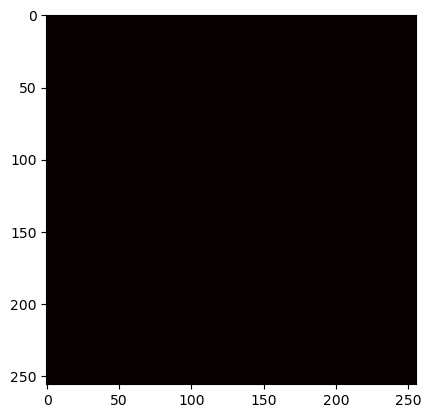

In [33]:
plt.imshow(psnr_map.detach().cpu().numpy()[0,0], cmap='hot')
plt.show()

In [20]:
img_input.shape

torch.Size([32, 1, 256, 256])

In [20]:
AttnUNet.forward(img_input.to(device), psnr_map.to(device)).shape

torch.Size([32, 1, 256, 256])

In [22]:
AttnUNet.forward(img_input.to(device)).shape

torch.Size([32, 1, 256, 256])

In [29]:
AttnUNet.forward(img_input.to(device)).shape

torch.Size([32, 1, 256, 256])

In [34]:
AttnUNet.forward(img_input.to(device)).shape

torch.Size([32, 1, 256, 256])

In [26]:
AttnUNet.forward(img_input.to(device)).shape

torch.Size([32, 1, 256, 256])

In [39]:
AttnUNet.forward(img_input.to(device)).shape

torch.Size([32, 1, 256, 256])

In [41]:
AttnUNet.forward(img_input.to(device)).shape

torch.Size([32, 1, 256, 256])

In [18]:
AttnUNet.forward(img_input.to(device)).shape

torch.Size([32, 1, 256, 256])

In [21]:
AttnUNet.forward(img_input.to(device)).shape

torch.Size([32, 1, 256, 256])

In [15]:
AttnUNet.forward(img_input.to(device)).shape

torch.Size([32, 1, 256, 256])

In [15]:
AttnUNet.forward(img_input.to(device), psnr_map.to(device).min()).shape

torch.Size([32, 1, 256, 256])